In [1]:
import app.calibration as cal
import app.edges as e
import app.warp as w
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

loaded


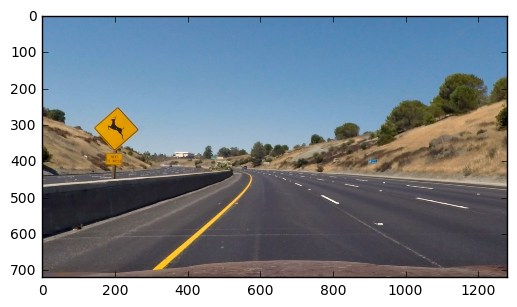

In [2]:
calibrator = cal.Camera_calibrator()
calibrator.initialize()

img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = calibrator.calibrate(img)

plt.imshow(undist)

In [5]:
edges = e.Edges(undist) 
gx_im = edges.gradient_x()
gc_im = edges.gradient_color_channel()

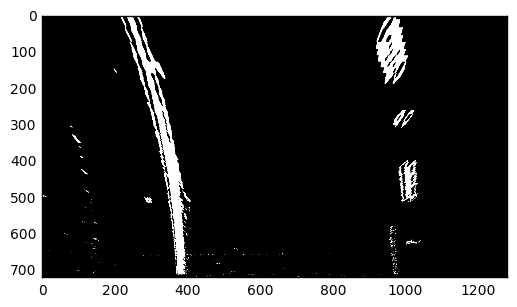

In [4]:
warped = w.warp(edges.combined)
plt.imshow(warped, cmap='gray')

In [6]:
warped.nonzero()

(array([  0,   0,   0, ..., 719, 719, 719]),
 array([213, 214, 215, ..., 891, 926, 928]))

In [7]:
warped.nonzero().shape

AttributeError: 'tuple' object has no attribute 'shape'